## Description of Notebook

The notebook is used to test ML approach on the VDF statistical momentsa, anisotropies, and particle numbers for species

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

C:\Users\Slava\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


## Test 1. Some standard classifiers.

In [2]:
featurevector_allmoments = np.load('./mldata_vdfmoments/allsimulations.mldata_moments.npy')
labels_allmoments = np.load('./mldata_vdfmoments/allsimulations.mldata_labels.npy')
times_allmoments = np.load('./mldata_vdfmoments/allsimulations.mldata_timep.npy')
print('The total number of data points is: ' + str(len(labels_allmoments)))
print('Among them unstable (positive) samples: ' + str(len(np.where(labels_allmoments == 1)[0])))

The total number of data points is: 997
Among them unstable (positive) samples: 392


In [3]:
scaler = StandardScaler()
scaler.fit(featurevector_allmoments)
featurevector_allmoments = scaler.transform(featurevector_allmoments)

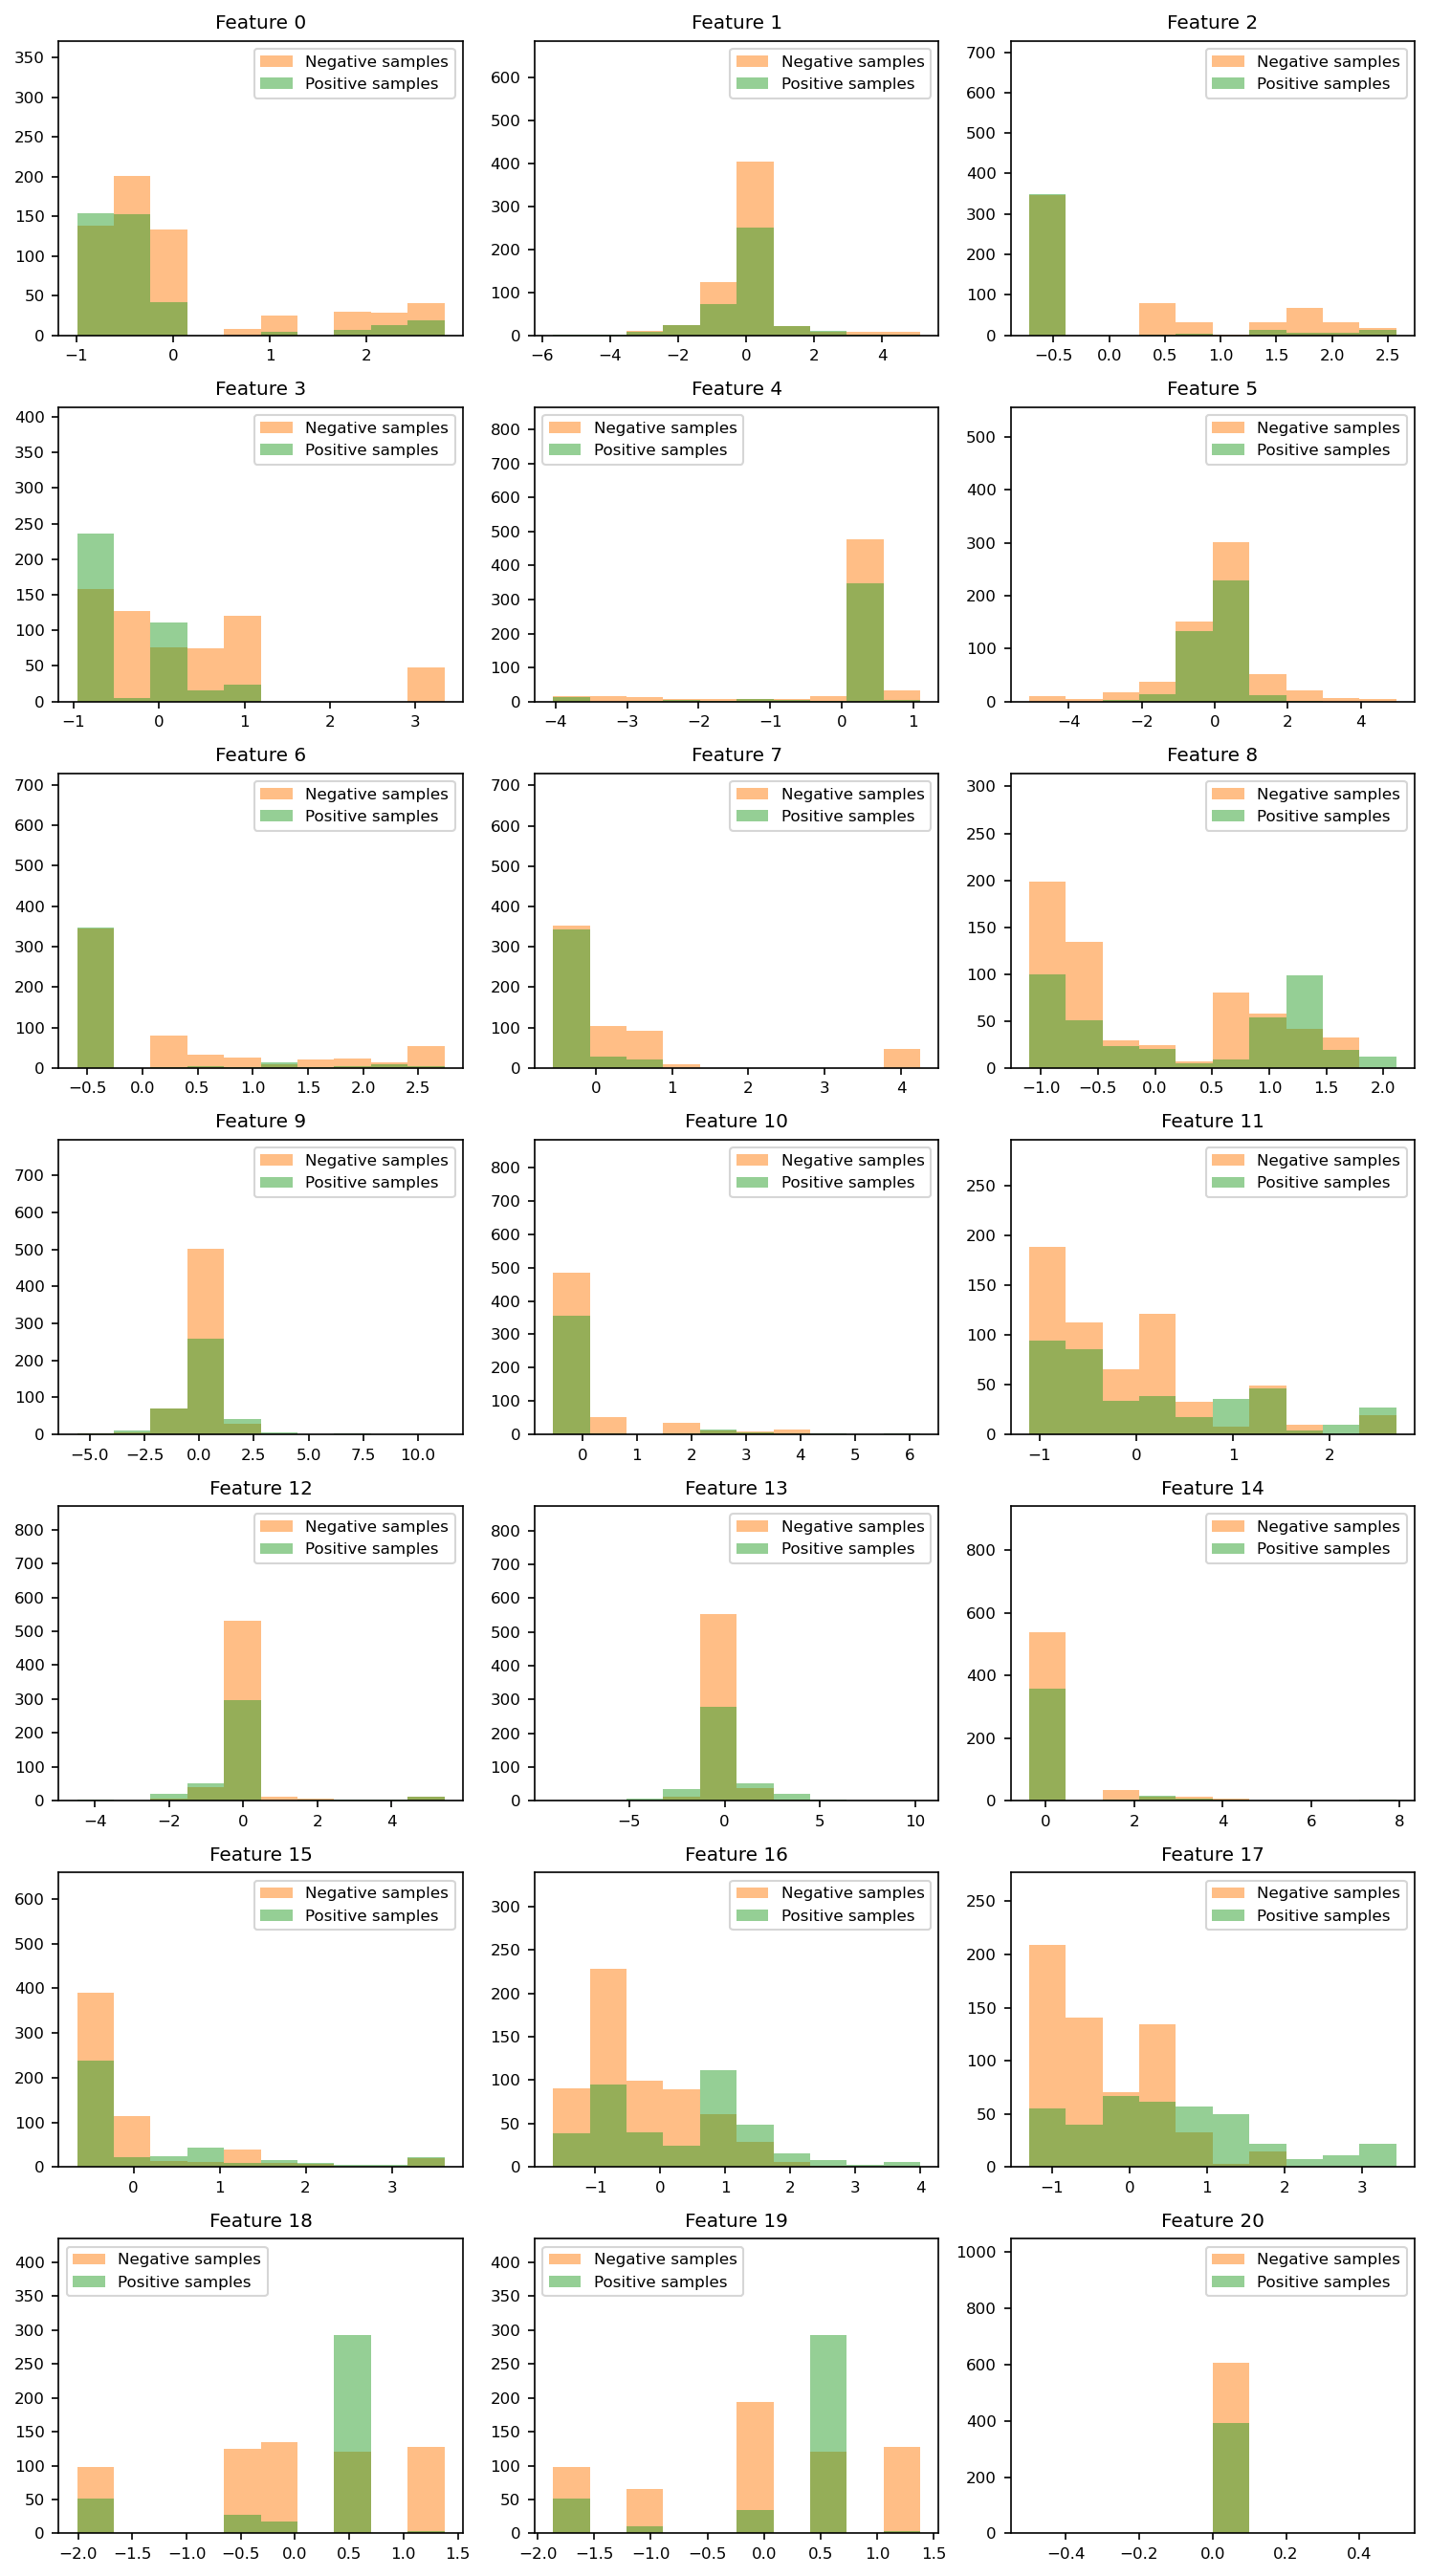

In [4]:
index_0 = np.where(labels_allmoments == 0)[0]
index_1 = np.where(labels_allmoments == 1)[0]

matplotlib.rcParams.update({'font.size':8})
im, ax = plt.subplots(7, 3, figsize = (10, 18), dpi=150)
for i in range (0, 7, 1):
    for j in range (0, 3, 1):
        hist, bins, patches = ax[i,j].hist(featurevector_allmoments[:,i*3+j], bins=10, alpha=0.00)
        ax[i,j].hist(featurevector_allmoments[index_0,i*3+j], bins=bins, label='Negative samples', alpha=0.50)
        ax[i,j].hist(featurevector_allmoments[index_1,i*3+j], bins=bins, label='Positive samples', alpha=0.50)
        ax[i,j].set(title='Feature '+str(i*3+j))
        ax[i,j].legend()

plt.tight_layout()
plt.show()

In [5]:
def outputclass_analysis(test_labels, predicted_labels, output_score=''):
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()
    print("------------ SUMMARY OF CLASSIFICATION RESULTS ----------------")
    print("TP = "+str(tp))
    print("TN = "+str(tn))
    print("FP = "+str(fp))
    print("FN = "+str(fn))
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    acc = (tp+tn)/(tp+fn+fp+tn)
    tss = tp/(tp+fn) - fp/(fp+tn)
    hss = 2*(tp*tn - fp*fn)/((tp+fn)*(fn+tn) + (tp+fp)*(fp+tn))
    print("Precision = "+str(precision))
    print("Recall = "+str(recall))
    print("Accuracy = "+str(acc))
    print("TSS = "+str(tss))
    print("HSS = "+str(hss))
    if (output_score == 'TSS'): return tss
    if (output_score == 'HSS'): return hss
    if (output_score == 'precision'): return precision
    if (output_score == 'accuracy'): return acc
    return

In [6]:
X_train, X_test, f_train, f_test = train_test_split(featurevector_allmoments, labels_allmoments, test_size=0.33, random_state=1)

K-Nearest Neighbor approach (see n_neighbors = 1 case, which is very interesting)

In [7]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, f_train)
f_predicted = clf.predict(X_test)
outputclass_analysis(f_test, f_predicted)

------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 105
TN = 188
FP = 15
FN = 22
Precision = 0.875
Recall = 0.8267716535433071
Accuracy = 0.8878787878787879
TSS = 0.7528800279275435
HSS = 0.7607289829512052


An SVM with the weight balancing setup

In [8]:
clf = SVC(kernel='rbf', class_weight='balanced')
clf.fit(X_train, f_train)
f_predicted = clf.predict(X_test)
outputclass_analysis(f_test, f_predicted)

------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 108
TN = 170
FP = 33
FN = 19
Precision = 0.7659574468085106
Recall = 0.8503937007874016
Accuracy = 0.8424242424242424
TSS = 0.6878321244327218
HSS = 0.6739254360962262


A very simple neural network with the hidden layer size of 50

In [9]:
clf = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', solver='adam', max_iter=10000, tol=1e-6)
clf.fit(X_train, f_train)
f_predicted = clf.predict(X_test)
outputclass_analysis(f_test, f_predicted)

------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 112
TN = 192
FP = 11
FN = 15
Precision = 0.9105691056910569
Recall = 0.8818897637795275
Accuracy = 0.9212121212121213
TSS = 0.8277025716613009
HSS = 0.832611494791057


Random forest

In [10]:
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, f_train)
f_predicted = clf.predict(X_test)
outputclass_analysis(f_test, f_predicted)

------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 118
TN = 198
FP = 5
FN = 9
Precision = 0.959349593495935
Recall = 0.9291338582677166
Accuracy = 0.9575757575757575
TSS = 0.9045033163957954
HSS = 0.9098677279644153


## Test 2. Separation into chunks of data.

In [11]:
featurevector_allmoments = np.load('./mldata_vdfmoments/allsimulations.mldata_moments.npy')
labels_allmoments = np.load('./mldata_vdfmoments/allsimulations.mldata_labels.npy')
times_allmoments = np.load('./mldata_vdfmoments/allsimulations.mldata_timep.npy')
print('The total number of data points is: ' + str(len(labels_allmoments)))
print('Among them unstable (positive) samples: ' + str(len(np.where(labels_allmoments == 1)[0])))

The total number of data points is: 997
Among them unstable (positive) samples: 392


In [12]:
scaler = StandardScaler()
scaler.fit(featurevector_allmoments)
featurevector_allmoments = scaler.transform(featurevector_allmoments)

In [13]:
def separate_chunksizebased(featurevector_allmoments, labels_allmoments, chunksize):

    X_train = []
    X_test = []
    f_train = []
    f_test = []

    mode = 'train'
    for i in range (0, len(labels_allmoments), chunksize):
        _chunksize = chunksize
        if (i + chunksize > len(labels_allmoments)): _chunksize = len(labels_allmoments) - i
        if (mode == 'train'):
            for j in range (0, _chunksize, 1):
                X_train.append(featurevector_allmoments[i+j,:])
                f_train.append(labels_allmoments[i+j])
            mode = 'test'
            continue
        if (mode == 'test'):
            for j in range (0, _chunksize, 1):
                X_test.append(featurevector_allmoments[i+j,:])
                f_test.append(labels_allmoments[i+j])
            mode = 'train'
            continue

    X_train = np.array(X_train, dtype=float)
    X_test = np.array(X_test, dtype=float)
    f_train = np.array(f_train, dtype=float)
    f_test = np.array(f_test, dtype=float)
    
    print("The size of the chunk:", chunksize)
    print("Number of positive - negative samples in train: " + str(np.sum(f_train)) + " --- " + str(len(f_train)-np.sum(f_train)))
    print("Number of positive - negative samples in test: " + str(np.sum(f_test)) + " --- " + str(len(f_test)-np.sum(f_test)))
    
    return X_train, X_test, f_train, f_test

output_scores = []
chunksizes = np.arange(2, 102, 2)

for chunksize in chunksizes:
    X_train, X_test, f_train, f_test = separate_chunksizebased(featurevector_allmoments, labels_allmoments, chunksize)
    clf = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', solver='adam', max_iter=10000)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    output_scores.append(outputclass_analysis(f_test, f_predicted, output_score='accuracy'))

The size of the chunk: 2
Number of positive - negative samples in train: 197.0 --- 302.0
Number of positive - negative samples in test: 195.0 --- 303.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 170
TN = 287
FP = 16
FN = 25
Precision = 0.9139784946236559
Recall = 0.8717948717948718
Accuracy = 0.9176706827309237
TSS = 0.818989591266819
HSS = 0.8257820099319101
The size of the chunk: 4
Number of positive - negative samples in train: 201.0 --- 299.0
Number of positive - negative samples in test: 191.0 --- 306.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 164
TN = 284
FP = 22
FN = 27
Precision = 0.8817204301075269
Recall = 0.8586387434554974
Accuracy = 0.9014084507042254
TSS = 0.7867433186188961
HSS = 0.7906324956799092
The size of the chunk: 6
Number of positive - negative samples in train: 186.0 --- 313.0
Number of positive - negative samples in test: 206.0 --- 292.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 16

------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 130
TN = 245
FP = 58
FN = 51
Precision = 0.6914893617021277
Recall = 0.7182320441988951
Accuracy = 0.7747933884297521
TSS = 0.5268129022847037
HSS = 0.5227428984982811
The size of the chunk: 46
Number of positive - negative samples in train: 206.0 --- 300.0
Number of positive - negative samples in test: 186.0 --- 305.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 86
TN = 234
FP = 71
FN = 100
Precision = 0.5477707006369427
Recall = 0.46236559139784944
Accuracy = 0.6517311608961304
TSS = 0.2295787061519478
HSS = 0.23678062703960584
The size of the chunk: 48
Number of positive - negative samples in train: 183.0 --- 334.0
Number of positive - negative samples in test: 209.0 --- 271.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 149
TN = 236
FP = 35
FN = 60
Precision = 0.8097826086956522
Recall = 0.7129186602870813
Accuracy = 0.8020833333333334
TSS = 0.5837673687741661
HSS = 

------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 89
TN = 216
FP = 79
FN = 85
Precision = 0.5297619047619048
Recall = 0.5114942528735632
Accuracy = 0.650319829424307
TSS = 0.24369764270407168
HSS = 0.2454333195989562
The size of the chunk: 90
Number of positive - negative samples in train: 202.0 --- 338.0
Number of positive - negative samples in test: 190.0 --- 267.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 115
TN = 190
FP = 77
FN = 75
Precision = 0.5989583333333334
Recall = 0.6052631578947368
Accuracy = 0.6673960612691466
TSS = 0.3168736447861226
HSS = 0.3163934103568406
The size of the chunk: 92
Number of positive - negative samples in train: 208.0 --- 329.0
Number of positive - negative samples in test: 184.0 --- 276.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 132
TN = 159
FP = 117
FN = 52
Precision = 0.5301204819277109
Recall = 0.717391304347826
Accuracy = 0.6326086956521739
TSS = 0.2934782608695652
HSS = 0.2

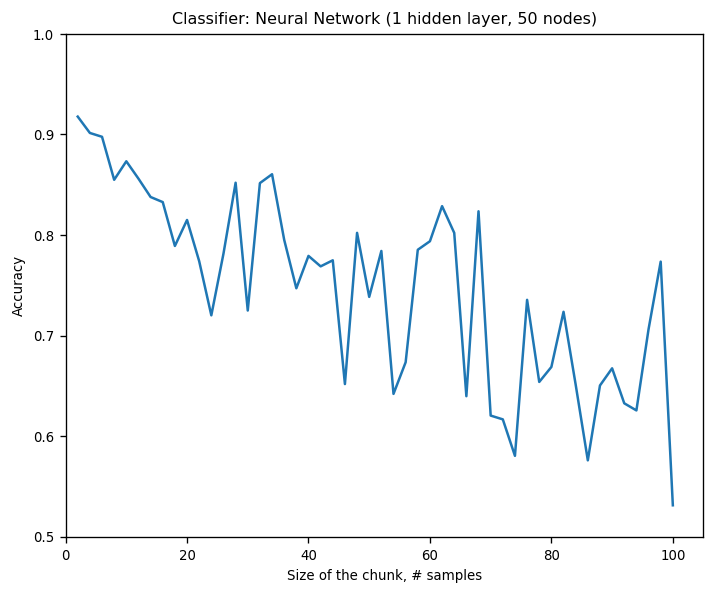

In [14]:
im, ax = plt.subplots(1, 1, figsize=(6,5), dpi=120)
ax.plot(chunksizes, output_scores)
ax.set(xlim=[0.0,105.0], ylim=[0.5,1.0], xlabel='Size of the chunk, # samples', ylabel='Accuracy', \
       title='Classifier: Neural Network (1 hidden layer, 50 nodes)')
plt.tight_layout()
plt.show()

In [15]:
def separate_chunksizebased(featurevector_allmoments, labels_allmoments, chunksize):

    X_train = []
    X_test = []
    f_train = []
    f_test = []

    mode = 'train'
    for i in range (0, len(labels_allmoments), chunksize):
        _chunksize = chunksize
        if (i + chunksize > len(labels_allmoments)): _chunksize = len(labels_allmoments) - i
        if (mode == 'train'):
            for j in range (0, _chunksize, 1):
                X_train.append(featurevector_allmoments[i+j,:])
                f_train.append(labels_allmoments[i+j])
            mode = 'test'
            continue
        if (mode == 'test'):
            for j in range (0, _chunksize, 1):
                X_test.append(featurevector_allmoments[i+j,:])
                f_test.append(labels_allmoments[i+j])
            mode = 'train'
            continue

    X_train = np.array(X_train, dtype=float)
    X_test = np.array(X_test, dtype=float)
    f_train = np.array(f_train, dtype=float)
    f_test = np.array(f_test, dtype=float)
    
    print("The size of the chunk:", chunksize)
    print("Number of positive - negative samples in train: " + str(np.sum(f_train)) + " --- " + str(len(f_train)-np.sum(f_train)))
    print("Number of positive - negative samples in test: " + str(np.sum(f_test)) + " --- " + str(len(f_test)-np.sum(f_test)))
    
    return X_train, X_test, f_train, f_test

output_scores = []
chunksizes = np.arange(2, 102, 2)

for chunksize in chunksizes:
    X_train, X_test, f_train, f_test = separate_chunksizebased(featurevector_allmoments, labels_allmoments, chunksize)
    clf = SVC(kernel='rbf', class_weight='balanced')
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    output_scores.append(outputclass_analysis(f_test, f_predicted, output_score='accuracy'))

The size of the chunk: 2
Number of positive - negative samples in train: 197.0 --- 302.0
Number of positive - negative samples in test: 195.0 --- 303.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 169
TN = 257
FP = 46
FN = 26
Precision = 0.786046511627907
Recall = 0.8666666666666667
Accuracy = 0.8554216867469879
TSS = 0.7148514851485148
HSS = 0.7020194465220643
The size of the chunk: 4
Number of positive - negative samples in train: 201.0 --- 299.0
Number of positive - negative samples in test: 191.0 --- 306.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 167
TN = 259
FP = 47
FN = 24
Precision = 0.780373831775701
Recall = 0.8743455497382199
Accuracy = 0.8571428571428571
TSS = 0.7207507784963898
HSS = 0.7048026970728728
The size of the chunk: 6
Number of positive - negative samples in train: 186.0 --- 313.0
Number of positive - negative samples in test: 206.0 --- 292.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 173

The size of the chunk: 48
Number of positive - negative samples in train: 183.0 --- 334.0
Number of positive - negative samples in test: 209.0 --- 271.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 146
TN = 218
FP = 53
FN = 63
Precision = 0.7336683417085427
Recall = 0.6985645933014354
Accuracy = 0.7583333333333333
TSS = 0.5029926375818782
HSS = 0.5057607981679064
The size of the chunk: 50
Number of positive - negative samples in train: 189.0 --- 311.0
Number of positive - negative samples in test: 203.0 --- 294.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 160
TN = 214
FP = 80
FN = 43
Precision = 0.6666666666666666
Recall = 0.7881773399014779
Accuracy = 0.7525150905432596
TSS = 0.5160684963640629
HSS = 0.5019106827125991
The size of the chunk: 52
Number of positive - negative samples in train: 224.0 --- 296.0
Number of positive - negative samples in test: 168.0 --- 309.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP 

The size of the chunk: 98
Number of positive - negative samples in train: 234.0 --- 273.0
Number of positive - negative samples in test: 158.0 --- 332.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 118
TN = 209
FP = 123
FN = 40
Precision = 0.4896265560165975
Recall = 0.7468354430379747
Accuracy = 0.6673469387755102
TSS = 0.3763535153271313
HSS = 0.3308142165323324
The size of the chunk: 100
Number of positive - negative samples in train: 242.0 --- 258.0
Number of positive - negative samples in test: 150.0 --- 347.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 144
TN = 117
FP = 230
FN = 6
Precision = 0.3850267379679144
Recall = 0.96
Accuracy = 0.5251509054325956
TSS = 0.2971757925072046
HSS = 0.2087055077313328


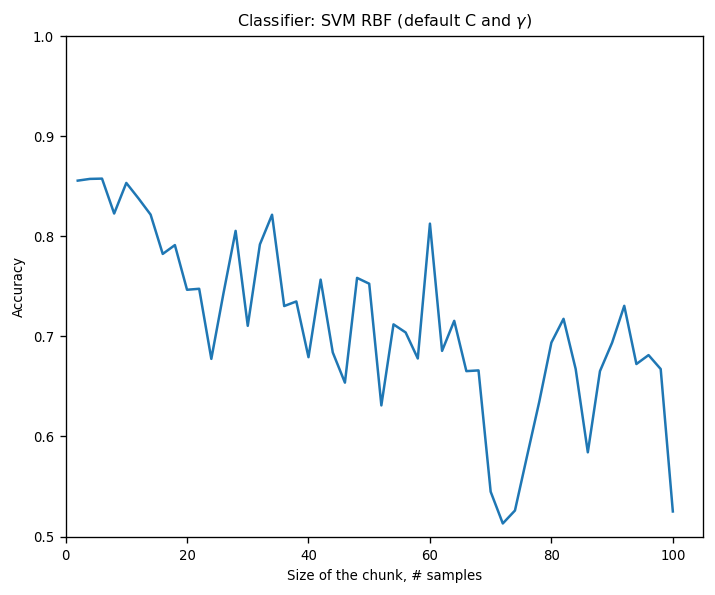

In [16]:
im, ax = plt.subplots(1, 1, figsize=(6,5), dpi=120)
ax.plot(chunksizes, output_scores)
ax.set(xlim=[0.0,105.0], ylim=[0.5,1.0], xlabel='Size of the chunk, # samples', ylabel='Accuracy', \
       title=r'Classifier: SVM RBF (default C and $\gamma$)')
plt.tight_layout()
plt.show()

In [17]:
def separate_chunksizebased(featurevector_allmoments, labels_allmoments, chunksize):

    X_train = []
    X_test = []
    f_train = []
    f_test = []

    mode = 'train'
    for i in range (0, len(labels_allmoments), chunksize):
        _chunksize = chunksize
        if (i + chunksize > len(labels_allmoments)): _chunksize = len(labels_allmoments) - i
        if (mode == 'train'):
            for j in range (0, _chunksize, 1):
                X_train.append(featurevector_allmoments[i+j,:])
                f_train.append(labels_allmoments[i+j])
            mode = 'test'
            continue
        if (mode == 'test'):
            for j in range (0, _chunksize, 1):
                X_test.append(featurevector_allmoments[i+j,:])
                f_test.append(labels_allmoments[i+j])
            mode = 'train'
            continue

    X_train = np.array(X_train, dtype=float)
    X_test = np.array(X_test, dtype=float)
    f_train = np.array(f_train, dtype=float)
    f_test = np.array(f_test, dtype=float)
    
    print("The size of the chunk:", chunksize)
    print("Number of positive - negative samples in train: " + str(np.sum(f_train)) + " --- " + str(len(f_train)-np.sum(f_train)))
    print("Number of positive - negative samples in test: " + str(np.sum(f_test)) + " --- " + str(len(f_test)-np.sum(f_test)))
    
    return X_train, X_test, f_train, f_test

output_scores = []
chunksizes = np.arange(2, 102, 2)

for chunksize in chunksizes:
    X_train, X_test, f_train, f_test = separate_chunksizebased(featurevector_allmoments, labels_allmoments, chunksize)
    clf = RandomForestClassifier(max_depth=10, random_state=0)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    output_scores.append(outputclass_analysis(f_test, f_predicted, output_score='accuracy'))

The size of the chunk: 2
Number of positive - negative samples in train: 197.0 --- 302.0
Number of positive - negative samples in test: 195.0 --- 303.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 179
TN = 299
FP = 4
FN = 16
Precision = 0.9781420765027322
Recall = 0.9179487179487179
Accuracy = 0.9598393574297188
TSS = 0.9047473978167047
HSS = 0.9147800195081883
The size of the chunk: 4
Number of positive - negative samples in train: 201.0 --- 299.0
Number of positive - negative samples in test: 191.0 --- 306.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 173
TN = 298
FP = 8
FN = 18
Precision = 0.9558011049723757
Recall = 0.9057591623036649
Accuracy = 0.9476861167002012
TSS = 0.8796153714539917
HSS = 0.8883551346961345
The size of the chunk: 6
Number of positive - negative samples in train: 186.0 --- 313.0
Number of positive - negative samples in test: 206.0 --- 292.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 177

------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 137
TN = 217
FP = 86
FN = 44
Precision = 0.6143497757847534
Recall = 0.7569060773480663
Accuracy = 0.731404958677686
TSS = 0.47307769450978243
HSS = 0.45196411462416164
The size of the chunk: 46
Number of positive - negative samples in train: 206.0 --- 300.0
Number of positive - negative samples in test: 186.0 --- 305.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 121
TN = 295
FP = 10
FN = 65
Precision = 0.9236641221374046
Recall = 0.6505376344086021
Accuracy = 0.8472505091649695
TSS = 0.6177507491627005
HSS = 0.6555675068980031
The size of the chunk: 48
Number of positive - negative samples in train: 183.0 --- 334.0
Number of positive - negative samples in test: 209.0 --- 271.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 138
TN = 237
FP = 34
FN = 71
Precision = 0.8023255813953488
Recall = 0.6602870813397129
Accuracy = 0.78125
TSS = 0.5348258267271668
HSS = 0.5458804872

------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 67
TN = 216
FP = 79
FN = 107
Precision = 0.4589041095890411
Recall = 0.3850574712643678
Accuracy = 0.603411513859275
TSS = 0.11726086109487627
HSS = 0.12126279313401564
The size of the chunk: 90
Number of positive - negative samples in train: 202.0 --- 338.0
Number of positive - negative samples in test: 190.0 --- 267.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 113
TN = 172
FP = 95
FN = 77
Precision = 0.5432692307692307
Recall = 0.5947368421052631
Accuracy = 0.6236323851203501
TSS = 0.23893159865957025
HSS = 0.23571164653948623
The size of the chunk: 92
Number of positive - negative samples in train: 208.0 --- 329.0
Number of positive - negative samples in test: 184.0 --- 276.0
------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 119
TN = 195
FP = 81
FN = 65
Precision = 0.595
Recall = 0.6467391304347826
Accuracy = 0.6826086956521739
TSS = 0.35326086956521735
HSS = 0.348214285

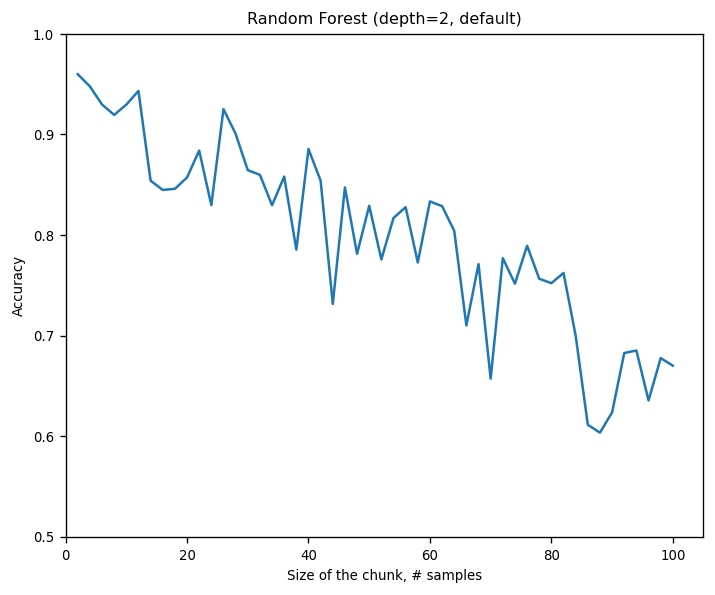

In [18]:
im, ax = plt.subplots(1, 1, figsize=(6,5), dpi=120)
ax.plot(chunksizes, output_scores)
ax.set(xlim=[0.0,105.0], ylim=[0.5,1.0], xlabel='Size of the chunk, # samples', ylabel='Accuracy', \
       title=r'Random Forest (depth=2, default)')
plt.tight_layout()
plt.show()

## Test 3. Treating the last three simulations as unknowns.

In [19]:
featurevector_allmoments = np.load('./mldata_vdfmoments/allsimulations.mldata_moments.npy')
labels_allmoments = np.load('./mldata_vdfmoments/allsimulations.mldata_labels.npy')
times_allmoments = np.load('./mldata_vdfmoments/allsimulations.mldata_timep.npy')
print('The total number of data points is: ' + str(len(labels_allmoments)))
print('Among them unstable (positive) samples: ' + str(len(np.where(labels_allmoments == 1)[0])))

The total number of data points is: 997
Among them unstable (positive) samples: 392


In [20]:
scaler = StandardScaler()
scaler.fit(featurevector_allmoments)
featurevector_allmoments = scaler.transform(featurevector_allmoments)

In [21]:
print(featurevector_allmoments.shape)
print(labels_allmoments.shape)

(997, 21)
(997,)


In [22]:
X_train = featurevector_allmoments[:-80,:]
X_test = featurevector_allmoments[-80:,:]
f_train = labels_allmoments[:-80]
f_test = labels_allmoments[-80:]

In [23]:
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, f_train)
f_predicted = clf.predict(X_test)
outputclass_analysis(f_test, f_predicted)

------------ SUMMARY OF CLASSIFICATION RESULTS ----------------
TP = 2
TN = 16
FP = 62
FN = 0
Precision = 0.03125
Recall = 1.0
Accuracy = 0.225
TSS = 0.20512820512820518
HSS = 0.012738853503184714


## Test 4. 10 random train-test pairs.

In [27]:
featurevector_allmoments = np.load('./mldata_vdfmoments/allsimulations.mldata_moments.npy')
labels_allmoments = np.load('./mldata_vdfmoments/allsimulations.mldata_labels.npy')
times_allmoments = np.load('./mldata_vdfmoments/allsimulations.mldata_timep.npy')
print('The total number of data points is: ' + str(len(labels_allmoments)))
print('Among them unstable (positive) samples: ' + str(len(np.where(labels_allmoments == 1)[0])))

The total number of data points is: 997
Among them unstable (positive) samples: 392


In [28]:
scaler = StandardScaler()
scaler.fit(featurevector_allmoments)
featurevector_allmoments = scaler.transform(featurevector_allmoments)

In [38]:
def outputclass_analysis_scorereturn(test_labels, predicted_labels):
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    acc = (tp+tn)/(tp+fn+fp+tn)
    tss = tp/(tp+fn) - fp/(fp+tn)
    hss = 2*(tp*tn - fp*fn)/((tp+fn)*(fn+tn) + (tp+fp)*(fp+tn))
    return tp, tn, fp, fn, acc, tss

In [39]:
tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for i in range (0, 10, 1):
    X_train, X_test, f_train, f_test = \
      train_test_split(featurevector_allmoments, labels_allmoments, test_size=0.33, random_state=i)
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp[i], tn[i], fp[i], fn[i], acc[i], tss[i] = outputclass_analysis_scorereturn(f_test, f_predicted)
    
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

TP = 104.7+/-7.184010022264724
TN = 189.2+/-6.029925372672534
FP = 11.7+/-3.3778691508109073
FN = 24.4+/-6.636264009214823
Acc = 0.8906060606060606+/-0.015945844990209537
TSS = 0.7540277365551376+/-0.039251367239285476


In [40]:
tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for i in range (0, 10, 1):
    X_train, X_test, f_train, f_test = \
      train_test_split(featurevector_allmoments, labels_allmoments, test_size=0.33, random_state=i)
    clf = SVC(kernel='rbf', class_weight='balanced')
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp[i], tn[i], fp[i], fn[i], acc[i], tss[i] = outputclass_analysis_scorereturn(f_test, f_predicted)
    
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

TP = 110.7+/-6.664082832618455
TN = 168.5+/-7.826237921249264
FP = 32.4+/-6.755738301621815
FN = 18.4+/-4.2708313008125245
Acc = 0.8460606060606061+/-0.0240064270549556
TSS = 0.6971275951085416+/-0.046400836802194353


In [41]:
tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for i in range (0, 10, 1):
    X_train, X_test, f_train, f_test = \
      train_test_split(featurevector_allmoments, labels_allmoments, test_size=0.33, random_state=i)
    clf = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', solver='adam', max_iter=10000, tol=1e-6)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp[i], tn[i], fp[i], fn[i], acc[i], tss[i] = outputclass_analysis_scorereturn(f_test, f_predicted)
    
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

TP = 113.3+/-7.253275122315436
TN = 189.2+/-7.704544113703289
FP = 11.7+/-1.8466185312619388
FN = 15.8+/-4.833218389437829
Acc = 0.9166666666666666+/-0.01616319436738739
TSS = 0.8199078243589752+/-0.036507940230552975


In [42]:
tp = np.zeros([10], dtype=int)
tn = np.zeros([10], dtype=int)
fp = np.zeros([10], dtype=int)
fn = np.zeros([10], dtype=int)
acc = np.zeros([10], dtype=float)
tss = np.zeros([10], dtype=float)

for i in range (0, 10, 1):
    X_train, X_test, f_train, f_test = \
      train_test_split(featurevector_allmoments, labels_allmoments, test_size=0.33, random_state=i)
    clf = RandomForestClassifier(max_depth=10, random_state=0)
    clf.fit(X_train, f_train)
    f_predicted = clf.predict(X_test)
    tp[i], tn[i], fp[i], fn[i], acc[i], tss[i] = outputclass_analysis_scorereturn(f_test, f_predicted)
    
print("TP = " + str(np.mean(tp)) + "+/-" + str(np.std(tp)))
print("TN = " + str(np.mean(tn)) + "+/-" + str(np.std(tn)))
print("FP = " + str(np.mean(fp)) + "+/-" + str(np.std(fp)))
print("FN = " + str(np.mean(fn)) + "+/-" + str(np.std(fn)))
print("Acc = " + str(np.mean(acc)) + "+/-" + str(np.std(acc)))
print("TSS = " + str(np.mean(tss)) + "+/-" + str(np.std(tss)))

TP = 120.1+/-7.217340230306452
TN = 197.0+/-7.483314773547883
FP = 3.9+/-2.808914381037628
FN = 9.0+/-3.4351128074635335
Acc = 0.9609090909090907+/-0.004781737526684706
TSS = 0.9113873763638886+/-0.014968899816957225
